# Preprocessing and Training Data Development

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data_wrangling.csv', parse_dates=['InvoiceDate'])
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,ItemTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


RFM score is a very common and useful approach when predicting customer lifetime value:  
- R - Recency  
- F - Frequency  
- M - Monetary Value

We are going to calculate Recency, Frequency and Monetary Value, and apply unsupervised machine learning to identify different groups (clusters) for each customer.

In [3]:
# get the time range of the dataset
print('Time range of the dataset: {} to {}'.format(df.InvoiceDate.min(), df.InvoiceDate.max()))
print('Number of months: {}'.format((df.InvoiceDate.max() - df.InvoiceDate.min())/np.timedelta64(1, 'M')))

Time range of the dataset: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Number of months: 24.25386330086632


The dataset has a total of 24 months of sales data. We will take 3 months of data, calculate the RFM score for each customer and use it for predicting the next 21 months LTV.

In [4]:
# create 3-month and 21-month dataframes 
df_3m = df[(df.InvoiceDate >= datetime(2009,12,1)) & (df.InvoiceDate < datetime(2010,3,1))]
df_21m = df[(df.InvoiceDate >= datetime(2010,3,1)) & (df.InvoiceDate < datetime(2011,12,1))]

In [5]:
# create a new dataframe to store CustomerID and the new features
customers = pd.DataFrame(df_3m['CustomerID'].unique())
customers.columns = ['CustomerID']
customers.head()

,CustomerID
0,13085
1,13078
2,15362
3,18102
4,12682


In [6]:
# create order cluster funtion

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

### Recency Score

We will calculate how many days has each customer been inactive for, then apply K-means clustering to assign each customer a recency score.

In [7]:
# get the most recent purchase date for each customer
df_recency = df_3m.groupby('CustomerID').InvoiceDate.max().rename('RecentPurchaseDate').reset_index()
df_recency.head()

,CustomerID,RecentPurchaseDate
0,12346,2010-01-26 17:27:00
1,12349,2009-12-04 12:49:00
2,12358,2009-12-08 07:59:00
3,12359,2009-12-16 15:39:00
4,12360,2010-02-22 09:32:00


In [8]:
# calculate the days between the recent puchase for each customer and the most recent purchase of the entire dataset
# this is the recency feature
df_recency['Recency'] = (df_recency['RecentPurchaseDate'].max() - df_recency['RecentPurchaseDate']).dt.days
df_recency.head()

,CustomerID,RecentPurchaseDate,Recency
0,12346,2010-01-26 17:27:00,32
1,12349,2009-12-04 12:49:00,86
2,12358,2009-12-08 07:59:00,82
3,12359,2009-12-16 15:39:00,74
4,12360,2010-02-22 09:32:00,6


In [9]:
# add the Recency feature to the dataframe
customers = customers.merge(df_recency[['CustomerID','Recency']], how='left', on='CustomerID')
customers.head()

,CustomerID,Recency
0,13085,30
1,13078,12
2,15362,89
3,18102,2
4,12682,5


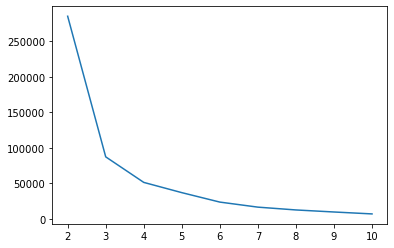

In [10]:
# use elbow method to pick the best K to cluster

Ks = range(2,11)
SS = []
for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(customers[['Recency']])
    SS.append(kmeans.inertia_)
    
plt.plot(Ks, SS)

In [11]:
# create 4 recency clusters and assign to each customer
kmeans = KMeans(n_clusters=4, random_state=0)
customers['RecencyCluster'] = kmeans.fit_predict(customers[['Recency']])
customers.head()

,CustomerID,Recency,RecencyCluster
0,13085,30,0
1,13078,12,2
2,15362,89,1
3,18102,2,2
4,12682,5,2


In [12]:
# check summary statistics for each cluster
customers.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,481.0,27.278586,5.215496,18.0,23.0,28.0,32.0,35.0
1,512.0,80.025391,5.931882,67.0,75.0,81.0,86.0,89.0
2,565.0,7.548673,4.976525,0.0,3.0,7.0,12.0,17.0
3,239.0,43.853556,5.213861,36.0,39.0,42.0,48.0,55.0


In [13]:
# order recency clusters
customers = order_cluster('RecencyCluster', 'Recency', customers, False)
customers.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,512.0,80.025391,5.931882,67.0,75.0,81.0,86.0,89.0
1,239.0,43.853556,5.213861,36.0,39.0,42.0,48.0,55.0
2,481.0,27.278586,5.215496,18.0,23.0,28.0,32.0,35.0
3,565.0,7.548673,4.976525,0.0,3.0,7.0,12.0,17.0


### Frequency Score

We will calculate the total number orders for each customer, then apply k-means clustering to assign each customer a frequency score.

In [14]:
# calculate freqency feature for each customer and add it to the dataframe
df_frequency = df_3m.groupby('CustomerID').Invoice.nunique().rename('Frequency').reset_index()
customers = customers.merge(df_frequency,how='left',on='CustomerID')
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,13085,30,2,6
1,18087,23,2,7
2,14110,28,2,3
3,13758,23,2,5
4,17865,20,2,10


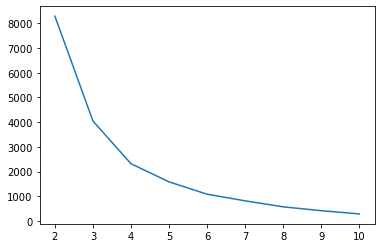

In [15]:
# user elbow method to pick the K
Ks = range(2,11)
SS = []
for K in Ks:
    kmeans = KMeans(n_clusters=K,random_state=0)
    kmeans.fit(customers[['Frequency']])
    SS.append(kmeans.inertia_)
    
plt.plot(Ks,SS)

In [16]:
# create 4 frequency clusters and assign to each customer
kmeans = KMeans(n_clusters=4, random_state=0)
customers['FrequencyCluster'] = kmeans.fit_predict(customers[['Frequency']])
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085,30,2,6,2
1,18087,23,2,7,2
2,14110,28,2,3,0
3,13758,23,2,5,2
4,17865,20,2,10,1


In [17]:
# check summary statistics for each frequency cluster
customers.groupby('FrequencyCluster').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1477.0,1.517942,0.720760,1.0,1.00,1.0,2.00,3.0
1,32.0,13.593750,3.358757,10.0,11.00,12.0,15.25,22.0
2,276.0,5.155797,1.316056,4.0,4.00,5.0,6.00,9.0
3,12.0,32.833333,8.110973,24.0,26.75,31.0,36.25,52.0


In [18]:
# order frequency clusters
customers = order_cluster('FrequencyCluster', 'Frequency', customers, True)
customers.groupby('FrequencyCluster').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1477.0,1.517942,0.720760,1.0,1.00,1.0,2.00,3.0
1,276.0,5.155797,1.316056,4.0,4.00,5.0,6.00,9.0
2,32.0,13.593750,3.358757,10.0,11.00,12.0,15.25,22.0
3,12.0,32.833333,8.110973,24.0,26.75,31.0,36.25,52.0


### Moneytary Value Score

We will calculate the revenue for each customer, and apply the same clustering method.

In [19]:
# calculate revenue for each customer and add it to the dataframe
df_revenue = df_3m.groupby('CustomerID').ItemTotal.sum().rename('Revenue').reset_index()
customers = customers.merge(df_revenue, how='left', on='CustomerID')
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,13085,30,2,6,1,2017.20
1,18087,23,2,7,1,1605.30
2,13758,23,2,5,1,2981.40
3,13097,33,2,5,1,1750.75
4,13711,35,2,7,1,937.65


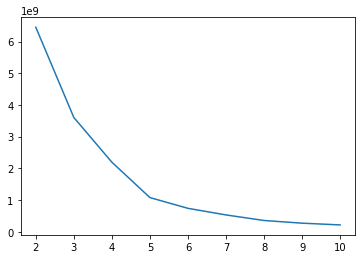

In [20]:
# user elbow method to pick the K
Ks = range(2,11)
SS = []
for K in Ks:
    kmeans = KMeans(n_clusters=K,random_state=0)
    kmeans.fit(customers[['Revenue']])
    SS.append(kmeans.inertia_)
    
plt.plot(Ks,SS)

In [21]:
# create 4 frequency clusters and assign to each customer
kmeans = KMeans(n_clusters=5, random_state=0)
customers['RevenueCluster'] = kmeans.fit_predict(customers[['Revenue']])

# check summary statistics for each revenue cluster
customers.groupby('RevenueCluster').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1681.0,479.893679,444.457395,-1426.21,181.640,337.67,660.000,2286.00
1,3.0,58466.720000,11469.409624,46682.53,52903.565,59124.60,64358.815,69593.03
2,9.0,17968.588889,4282.191690,11747.64,16299.170,16990.24,20372.630,24148.28
3,1.0,101837.940000,NaN,101837.94,101837.940,101837.94,101837.940,101837.94
4,103.0,4124.203825,1814.305309,2316.58,2858.710,3363.48,4953.700,9722.82


In [22]:
# order revenue clusters
customers = order_cluster('RevenueCluster','Revenue',customers,True)
customers.groupby('RevenueCluster').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1681.0,479.893679,444.457395,-1426.21,181.640,337.67,660.000,2286.00
1,103.0,4124.203825,1814.305309,2316.58,2858.710,3363.48,4953.700,9722.82
2,9.0,17968.588889,4282.191690,11747.64,16299.170,16990.24,20372.630,24148.28
3,3.0,58466.720000,11469.409624,46682.53,52903.565,59124.60,64358.815,69593.03
4,1.0,101837.940000,NaN,101837.94,101837.940,101837.94,101837.940,101837.94


In [23]:
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085,30,2,6,1,2017.20,0
1,18087,23,2,7,1,1605.30,0
2,13097,33,2,5,1,1750.75,0
3,13711,35,2,7,1,937.65,0
4,13819,20,2,4,1,1490.75,0


### RFM Score

We will sum up the frequency, recency, and monetary value to get a RFM score for each customer.

In [24]:
# calculate total score for each customer
customers['RFM'] = customers['RecencyCluster'] + customers['FrequencyCluster'] + customers['RevenueCluster']
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM
0,13085,30,2,6,1,2017.20,0,3
1,18087,23,2,7,1,1605.30,0,3
2,13097,33,2,5,1,1750.75,0,3
3,13711,35,2,7,1,937.65,0,3
4,13819,20,2,4,1,1490.75,0,3


In [25]:
# check summary statistics for RFM scores
customers.groupby('RFM')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
RFM,,,
0,80.237323,1.312373,287.683732
1,46.455752,1.676991,501.288761
2,28.605140,1.775701,455.989841
3,11.334917,2.209026,632.245729
4,8.678082,4.945205,1595.950692
5,7.625000,7.500000,3431.130646
6,4.947368,12.526316,7050.994842
7,2.222222,24.777778,9285.555556
8,2.750000,37.000000,30158.937500


### The Label - LTV Cluster

There is no cost specified in the dataset, so we will take the 21-month revenue as our LTV directly.

In [26]:
# calculate 21 months LTV for each customer
df_21m_revenue = df_21m.groupby('CustomerID').ItemTotal.sum().rename('Revenue21m').reset_index()
df_21m_revenue

,CustomerID,Revenue21m
0,12346,-147.24
1,12347,4696.71
2,12348,1658.40
3,12349,3678.69
4,12350,294.40
...,...,...
5671,18282,98.76
5672,18283,2360.00
5673,18284,436.68
5674,18286,725.48


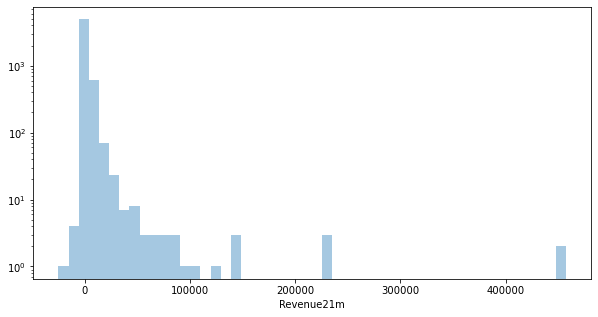

In [27]:
plt.figure(figsize=(10,5))
sns.distplot(df_21m_revenue.Revenue21m, kde=False)
plt.yscale('log')

Histogram clearly shows that we have some customers with negative LTV and some outliers. Instead of filtering out the outliers, we will winsorize them to get the data ready for model training.

In [28]:
# add 21 months LTV to the customers dataframe
customers = customers.merge(df_21m_revenue,how='left',on='CustomerID')
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m
0,13085,30,2,6,1,2017.20,0,3,-557.74
1,18087,23,2,7,1,1605.30,0,3,12806.32
2,13097,33,2,5,1,1750.75,0,3,11045.86
3,13711,35,2,7,1,937.65,0,3,694.96
4,13819,20,2,4,1,1490.75,0,3,1140.35


In [29]:
# fill in missing 21 months revenue as 0
customers.fillna(0,inplace=True)
customers.isnull().sum()

CustomerID          0
Recency             0
RecencyCluster      0
Frequency           0
FrequencyCluster    0
Revenue             0
RevenueCluster      0
RFM                 0
Revenue21m          0
dtype: int64

In [30]:
# winsorize outliers
winsorize(customers['Revenue21m'], limits=[0.01, 0.01], inplace=True)
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m
0,13085,30,2,6,1,2017.20,0,3,-2.95
1,18087,23,2,7,1,1605.30,0,3,12806.32
2,13097,33,2,5,1,1750.75,0,3,11045.86
3,13711,35,2,7,1,937.65,0,3,694.96
4,13819,20,2,4,1,1490.75,0,3,1140.35


LTV is a regression problem, but here we are going to create LTV segments, and predict which LTV segment the customer belongs to. Having LTV segments will allow businesses to extract more actionable insights and treat customers differently based on their predicted LTV segments.

For this project we will apply clustering and have 3 segments:
- Cluster 0: Low LTV
- Cluster 1: Mid LTV
- Cluster 2: High LTV

In [31]:
# create 3 LTV clusters and assign to each customer
kmeans = KMeans(n_clusters=3, random_state=0)
customers['LTVCluster'] = kmeans.fit_predict(customers[['Revenue21m']])
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m,LTVCluster
0,13085,30,2,6,1,2017.20,0,3,-2.95,0
1,18087,23,2,7,1,1605.30,0,3,12806.32,2
2,13097,33,2,5,1,1750.75,0,3,11045.86,2
3,13711,35,2,7,1,937.65,0,3,694.96,0
4,13819,20,2,4,1,1490.75,0,3,1140.35,0


In [32]:
# order LTV clusters: 0-low LTV, 1-Mid LTV, 2-High LTV
customers = order_cluster('LTVCluster','Revenue21m',customers,True)
customers.groupby('LTVCluster').Revenue21m.describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1580.0,1795.394908,1888.601922,-2.95,292.5725,1093.72,2819.8375,7605.65
1,186.0,13471.517855,5690.865184,7660.95,9144.9250,11517.26,16002.9450,32214.74
2,31.0,52106.483226,8346.273062,33417.53,46611.0300,58236.64,58236.6400,58236.64


Text(0, 0.5, '21-Month LTV')

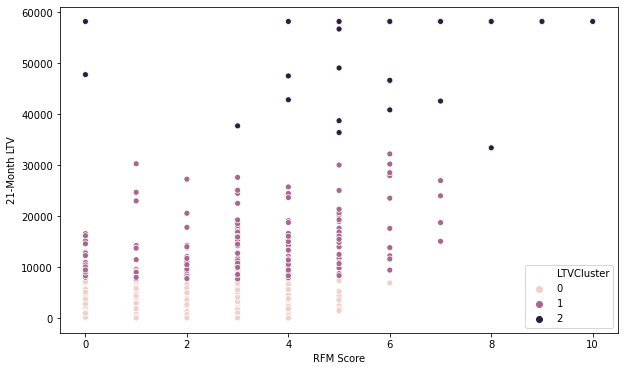

In [33]:
# examine the correlation between RFM score and 21 months LTV
plt.figure(figsize=(10,6))
sns.scatterplot('RFM','Revenue21m',data=customers,hue='LTVCluster')
plt.xlabel('RFM Score')
plt.ylabel('21-Month LTV')

We can observe correlation between the RFM score and the LTV segment from the scatter plot.

### Dummy Features - Country

In [34]:
# add country as a feature to the customer dataframe
customers = customers.merge(df_3m[['CustomerID','Country']].drop_duplicates(),how='left',on='CustomerID')
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m,LTVCluster,Country
0,13085,30,2,6,1,2017.20,0,3,-2.95,0,United Kingdom
1,13711,35,2,7,1,937.65,0,3,694.96,0,United Kingdom
2,13819,20,2,4,1,1490.75,0,3,1140.35,0,United Kingdom
3,16550,22,2,7,1,1665.74,0,3,6891.08,0,United Kingdom
4,17867,32,2,4,1,74.98,0,3,781.57,0,United Kingdom


In [35]:
# get dummy featues for country feature
customers = pd.get_dummies(customers, drop_first=True)
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m,LTVCluster,...,Country_Poland,Country_Portugal,Country_RSA,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,13085,30,2,6,1,2017.20,0,3,-2.95,0,...,0,0,0,0,0,0,0,0,1,0
1,13711,35,2,7,1,937.65,0,3,694.96,0,...,0,0,0,0,0,0,0,0,1,0
2,13819,20,2,4,1,1490.75,0,3,1140.35,0,...,0,0,0,0,0,0,0,0,1,0
3,16550,22,2,7,1,1665.74,0,3,6891.08,0,...,0,0,0,0,0,0,0,0,1,0
4,17867,32,2,4,1,74.98,0,3,781.57,0,...,0,0,0,0,0,0,0,0,1,0


### Train-Test Split

In [36]:
# create the feature set X and label y
X = customers.drop(['CustomerID','Revenue21m','LTVCluster'],axis=1)
y = customers.LTVCluster

In [37]:
# split training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#### Feature standardization

In [38]:
# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Country_Austria,Country_Belgium,Country_Channel Islands,...,Country_Poland,Country_Portugal,Country_RSA,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,-0.189700,0.298513,-0.423252,-0.421507,-0.241232,-0.240966,0.040443,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
1,0.358565,-0.535714,-0.154327,-0.421507,-0.117397,-0.240966,-0.585732,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
2,-1.217697,1.132741,8.989119,5.472296,3.741099,5.883216,3.797499,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
3,-0.498099,0.298513,-0.154327,-0.421507,-0.157006,-0.240966,0.040443,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
4,-1.183430,1.132741,0.114598,-0.421507,-0.146612,-0.240966,0.666619,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,-1.149163,1.132741,-0.423252,-0.421507,-0.155526,-0.240966,0.666619,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
1343,1.420828,-1.369941,-0.423252,-0.421507,-0.240541,-0.240966,-1.211908,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
1344,-1.286230,1.132741,0.114598,-0.421507,0.115800,-0.240966,0.666619,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
1345,-0.875031,1.132741,0.114598,-0.421507,0.101333,-0.240966,0.666619,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246


In [39]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns
X_test_scaled

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Country_Austria,Country_Belgium,Country_Channel Islands,...,Country_Poland,Country_Portugal,Country_RSA,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,1.592161,-1.369941,-0.154327,-0.421507,-0.214200,-0.240966,-1.211908,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
1,-0.463832,0.298513,0.921372,1.543094,0.786081,2.821125,1.292795,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
2,1.180962,-1.369941,0.114598,-0.421507,-0.100628,-0.240966,-1.211908,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
3,-0.806498,1.132741,-0.423252,-0.421507,-0.212954,-0.240966,0.666619,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
4,-0.086900,0.298513,0.114598,-0.421507,-0.099372,-0.240966,0.040443,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.050166,-0.535714,-0.423252,-0.421507,-0.172035,-0.240966,-0.585732,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
446,1.626428,-1.369941,-0.423252,-0.421507,-0.208462,-0.240966,-1.211908,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
447,0.495631,-0.535714,-0.423252,-0.421507,-0.205319,-0.240966,-0.585732,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246
448,-1.217697,1.132741,0.921372,1.543094,1.162496,2.821125,1.918971,-0.047246,-0.054575,-0.038561,...,-0.027257,-0.054575,-0.027257,-0.06689,-0.047246,-0.027257,-0.027257,-0.027257,0.280112,-0.047246


In [40]:
X_train.to_csv('X_train.csv',index=False)
X_train_scaled.to_csv('X_train_scaled.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
X_test_scaled.to_csv('X_test_scaled.csv',index=False)
y_train.to_csv('y_train.csv',index=False)
y_test.to_csv('y_test.csv',index=False)